# `imbibition`

Simulate pressure-controlled withdrawal of non-wetting fluid into an image using image-based sphere insertion.  

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import porespy as ps

ps.visualization.set_mpl_style()

## `im`
Can be a 2D or 3D image. To use the function properly a capillary transform should be computed and provided to `pc` argument. If `pc` is not given, however, the function will still work as `pc` is computed assuming $pc = 2/dt$.  

In [3]:
im = ps.generators.blobs(shape=[200, 200], porosity=0.7, blobiness=1, seed=0)
imb = ps.simulations.imbibition(im=im)

The function returns a ``Results`` object with a images containing the invasion sequence map , the saturation map, and capillary pressure map.  These are shown below:

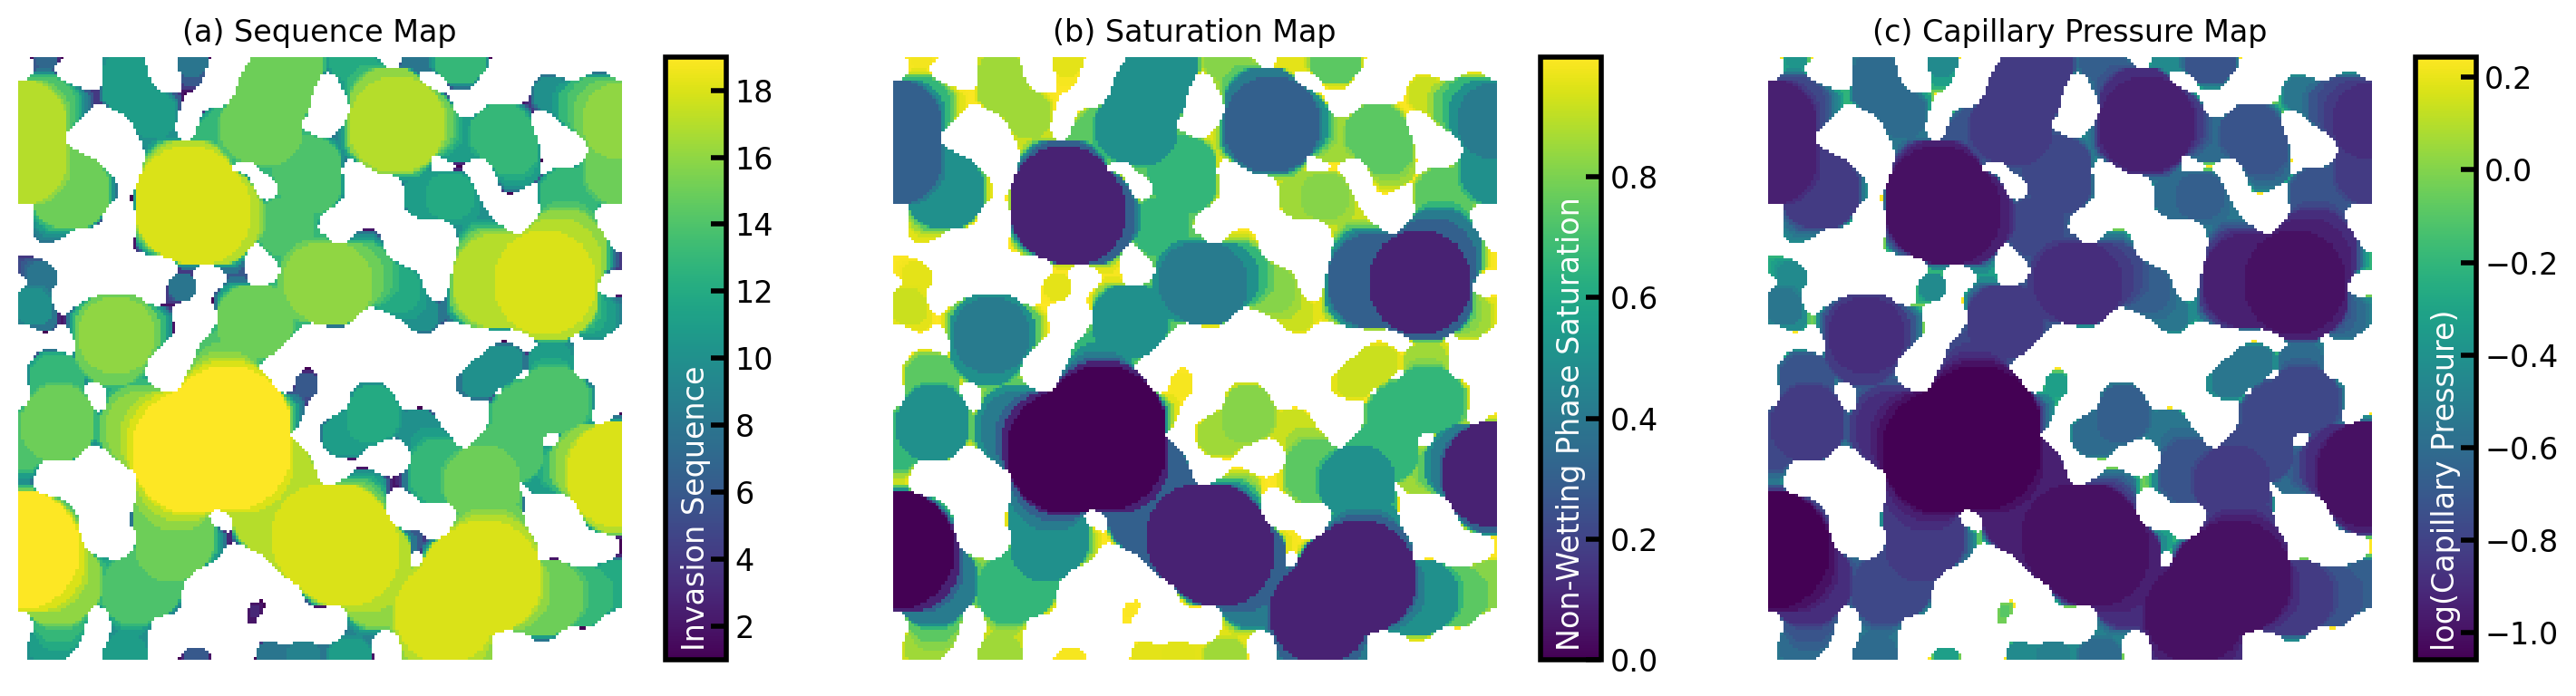

In [4]:
def plot_results(res):
    fig, ax = plt.subplots(1, 3, figsize=[15, 4])

    h = ax[0].imshow(res.im_seq/im, origin='lower')
    cbar = fig.colorbar(h, aspect=10, format="{x:.0f}")
    cbar.ax.set_title('Invasion Sequence', rotation=90, y=0, c='w')
    ax[0].axis(False)
    ax[0].set_title('(a) Sequence Map')

    h = ax[1].imshow(res.im_snwp/im, origin='lower')
    cbar = fig.colorbar(h, aspect=10, format="{x:.1f}")
    cbar.ax.set_title('Non-Wetting Phase Saturation', rotation=90, y=0, c='w')
    ax[1].axis(False)
    ax[1].set_title('(b) Saturation Map')

    h = ax[2].imshow(np.log10(res.im_pc)/im, origin='lower')
    cbar = fig.colorbar(h, aspect=10, format="{x:.1f}")
    cbar.ax.set_title('log(Capillary Pressure)', rotation=90, y=0, c='w')
    ax[2].axis(False)
    ax[2].set_title('(c) Capillary Pressure Map')

plot_results(imb)

## `inlets`
If `inlets` is not supplied, than the imbibition process will proceed without considering access limitations, meaning that the wetting fluid can appear at any location inside the domain that is favorable at the current capillary pressure.  If `inlets` are provided, than this will enforce an access-limited process, such that the imbibing fluid can only appear in regions that are connected to the the given `inlets`:

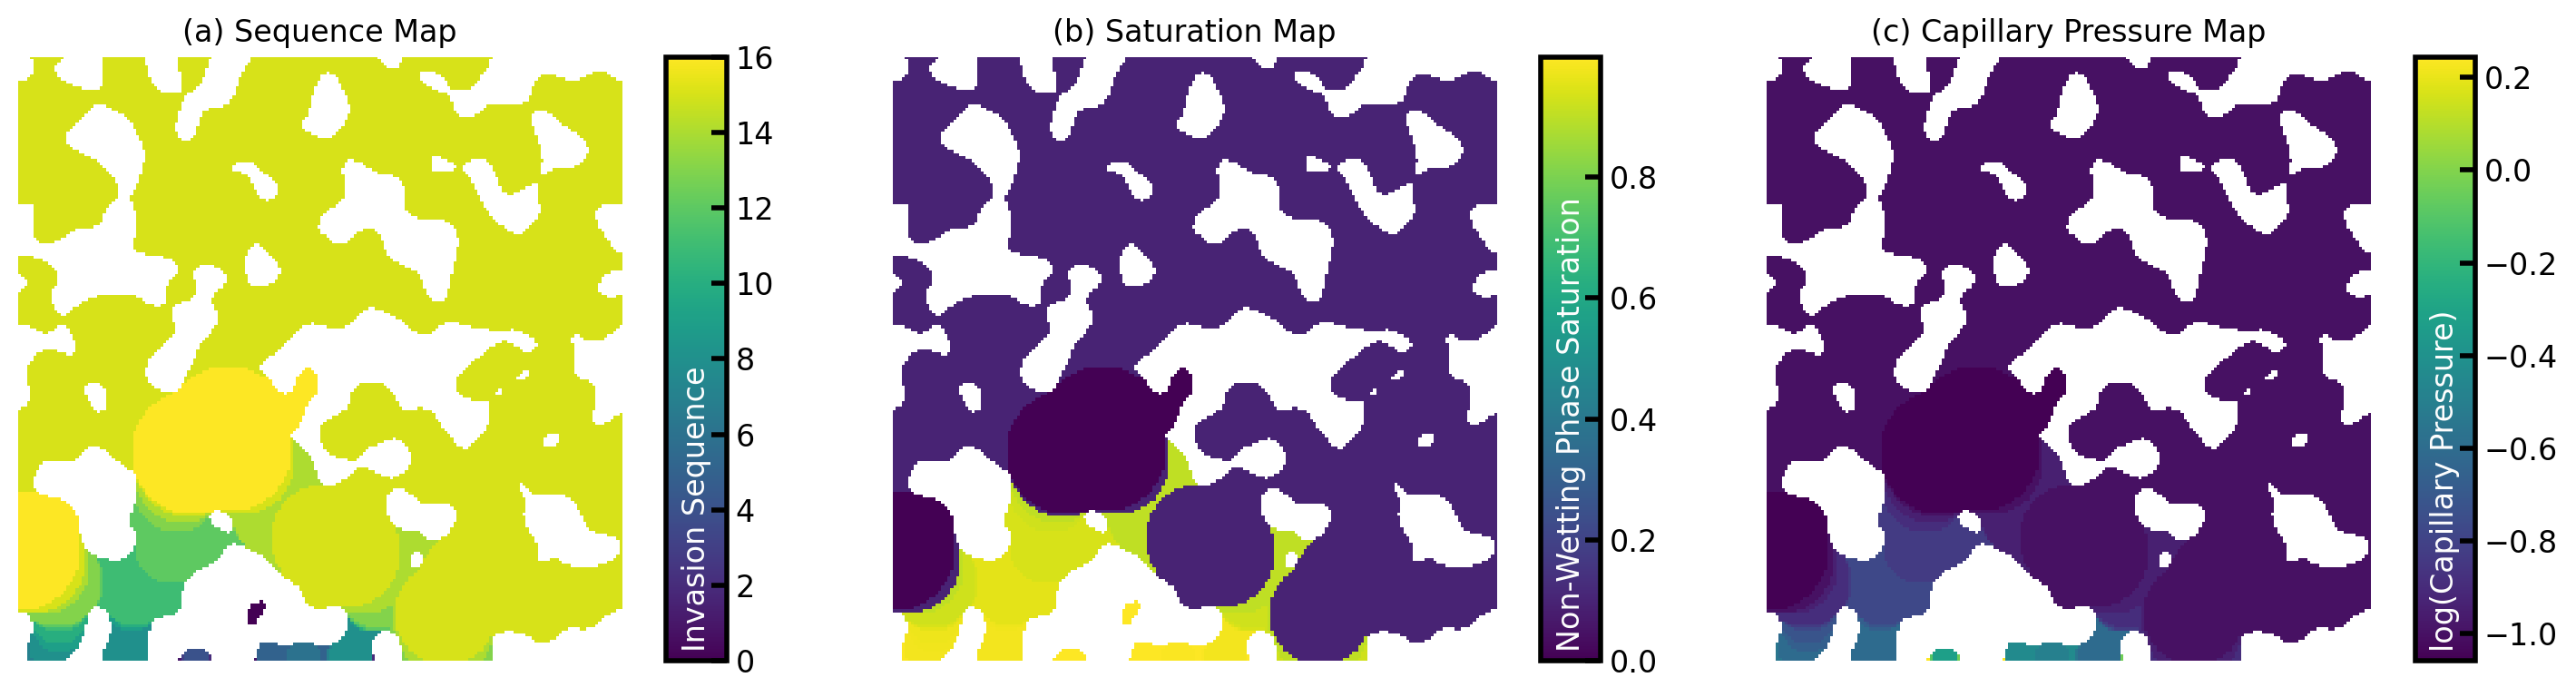

In [5]:
inlets = ps.generators.faces(im.shape, inlet=0)
imb = ps.simulations.imbibition(
    im=im,
    inlets=inlets,
)

plot_results(imb)

## `pc`

Supplying a capillary pressure transform as `pc` is how you tell `imbibition` what the capillary entry pressure of each voxel is. This is calculated separately (e.g. using `porespy.filters.capillary_transform`) so that you have maximum control over how this is calculated, for instance to include gravity.  In the following the effect of gravity can be noticed as the invasion preferentially occurs from the bottom left portion of the image (recall that the left edge is set as `inlets`)

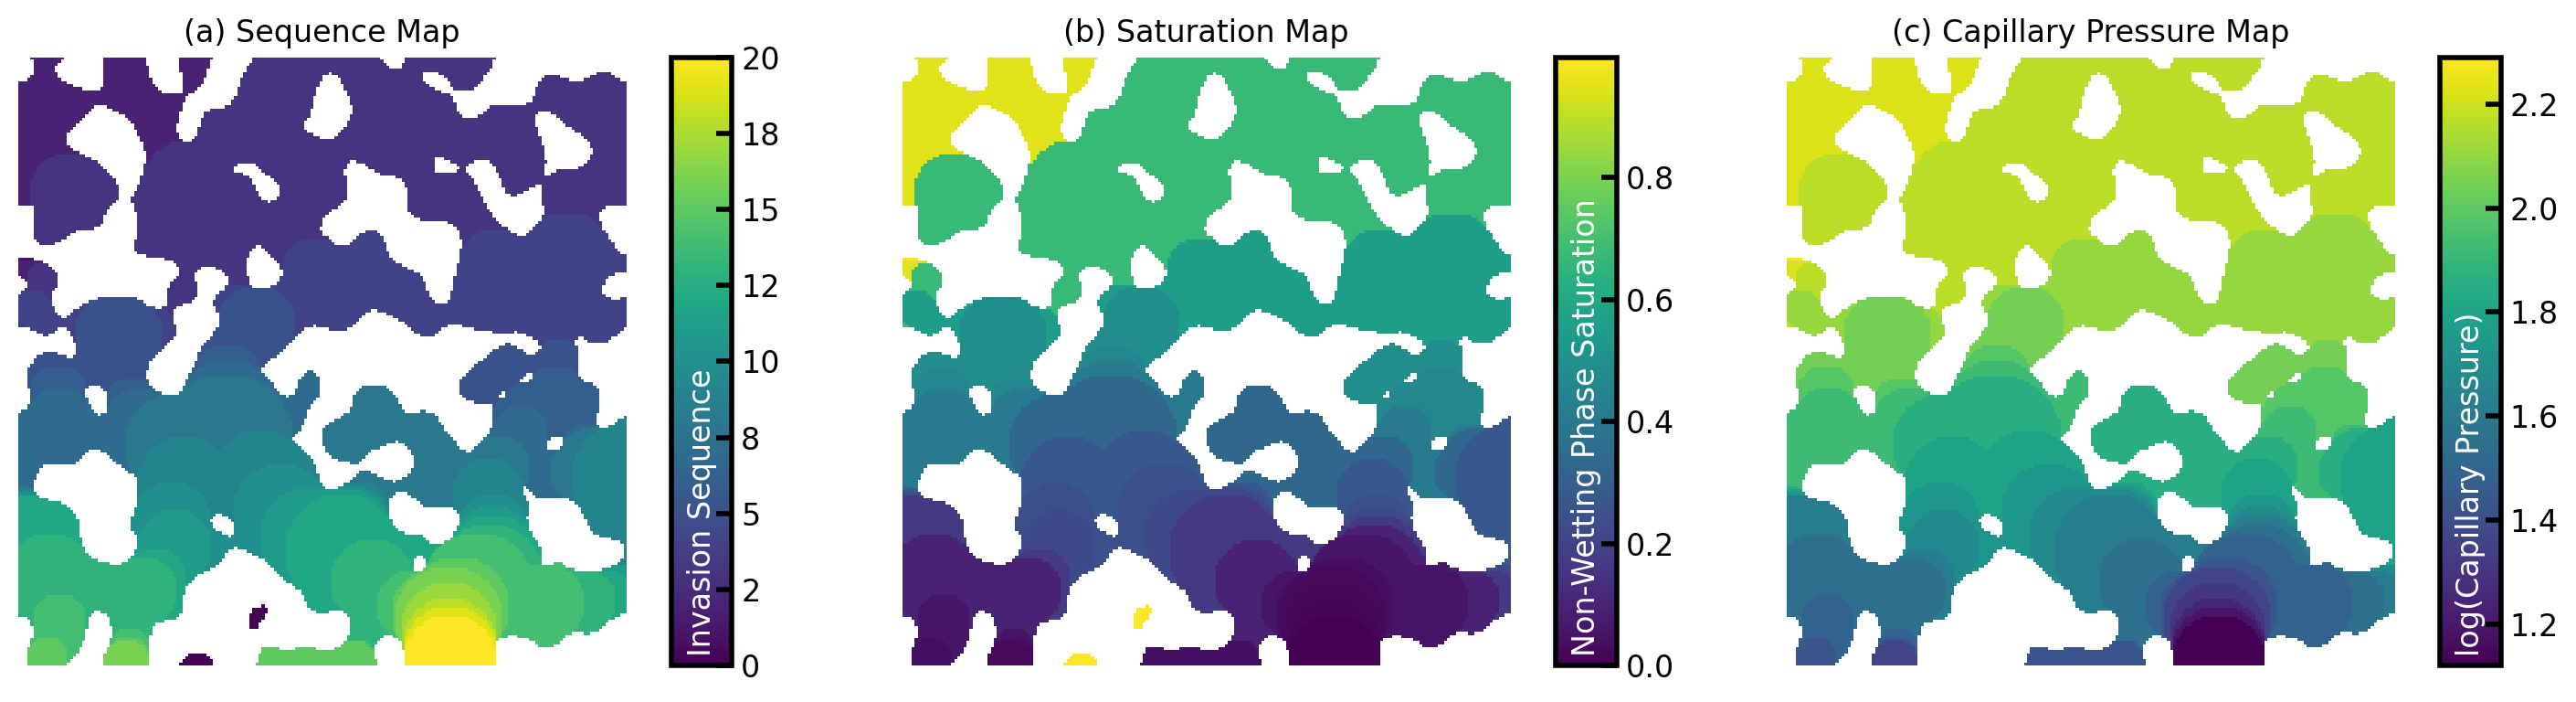

In [6]:
pc = ps.filters.capillary_transform(
    im=im,
    sigma=0.01,
    theta=180,
    g=9.81,
    rho_nwp=1000,
    rho_wp=0,
    voxel_size=1e-4,
)

inlets = ps.generators.faces(im.shape, inlet=1)
imb = ps.simulations.imbibition(
    im=im,
    pc=pc,
    inlets=inlets,
)

plot_results(imb)

## `outlets`

Of `outlets` are specified then trapping of the wetting phase is included in the returned displacement maps. In the example below there are some blobs of trapped non-wetting phase near the bottom of the image. They cannot escape since the outlets are on the right edge.

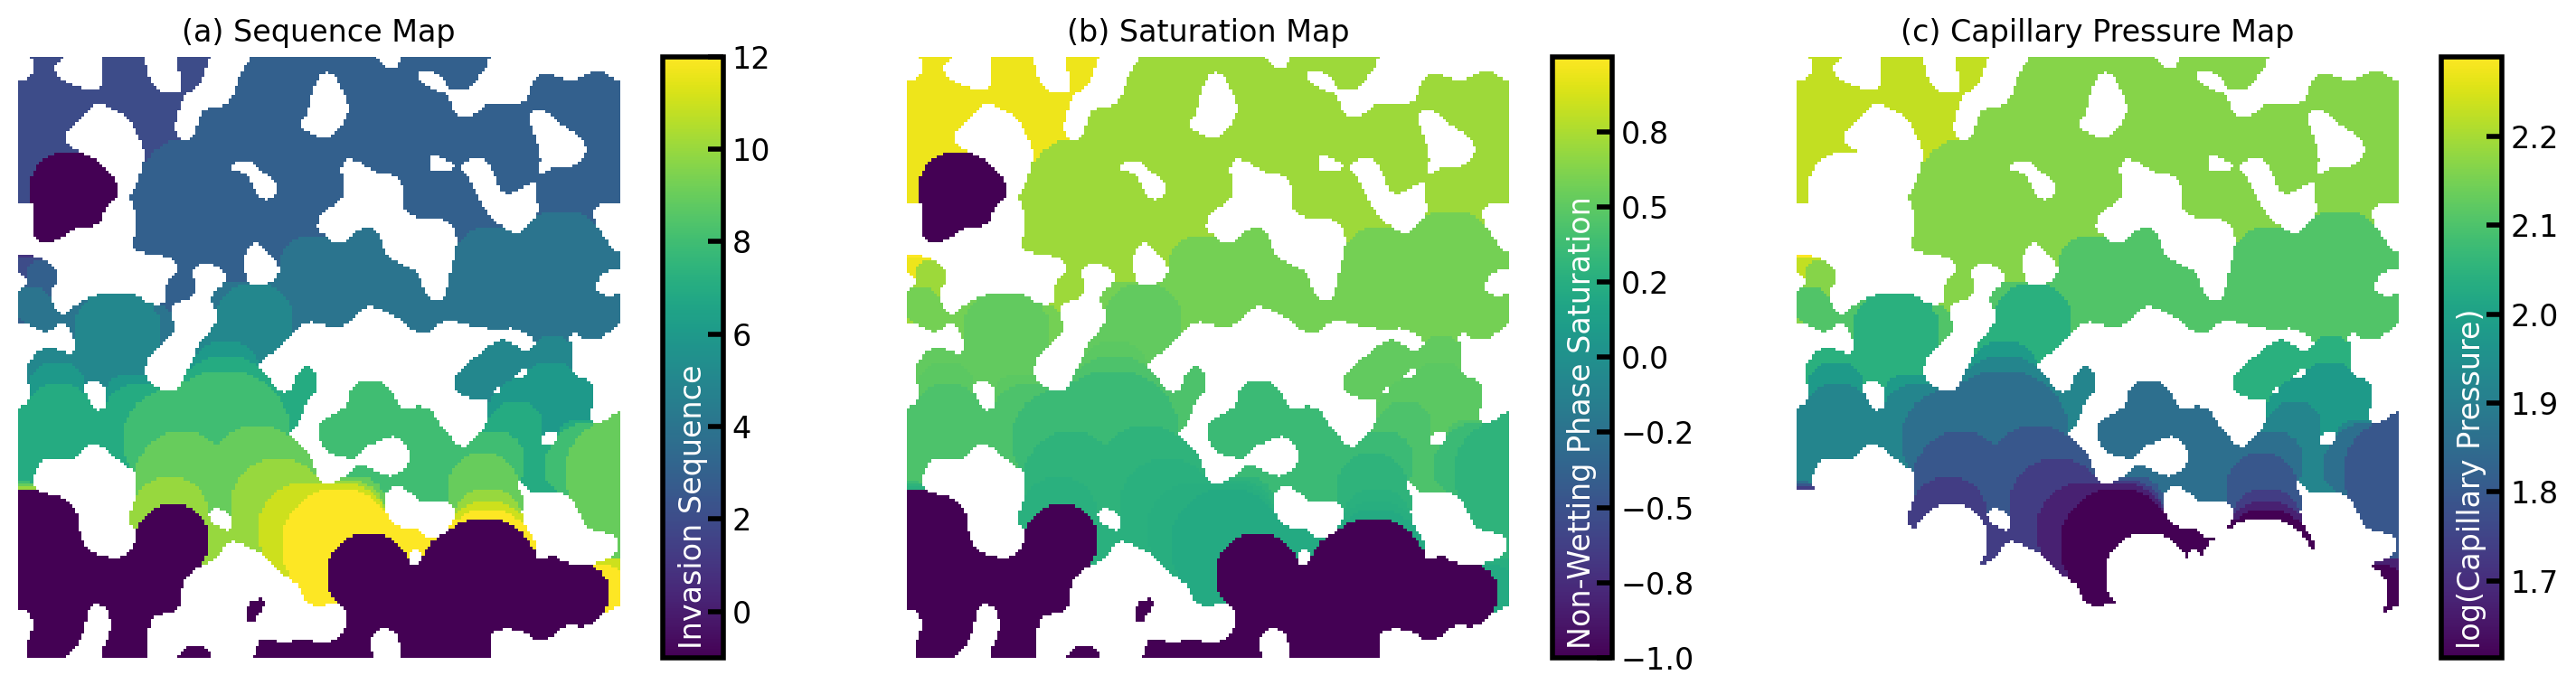

In [7]:
outlets = ps.generators.faces(im.shape, outlet=1)

imb = ps.simulations.imbibition(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
)

plot_results(imb)

## `residual`

It is possible to specify the locations of any residual non-wetting phase which may be present prior to the fluid injection.  These residual blobs impact the connecting of the invading fluid as well as the trapping of wetting phase:

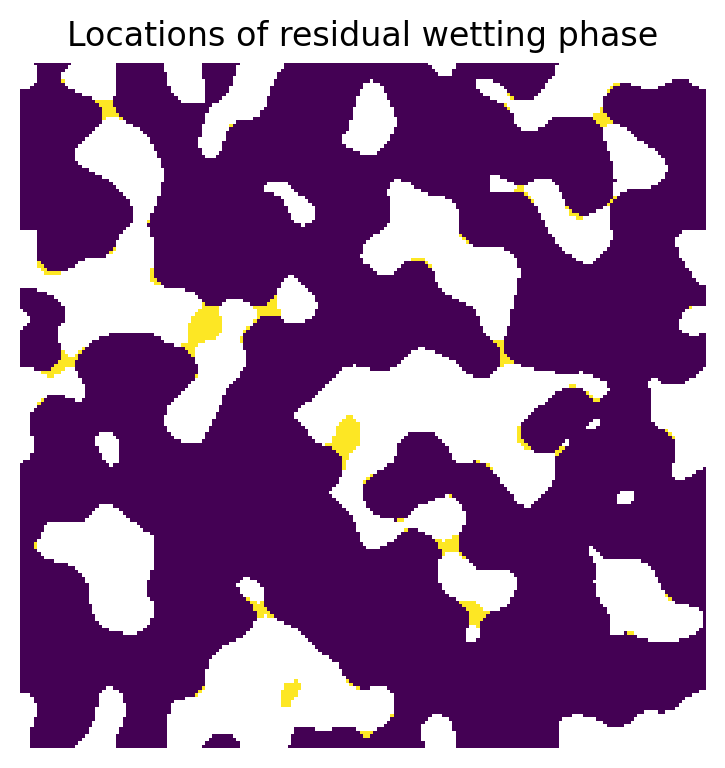

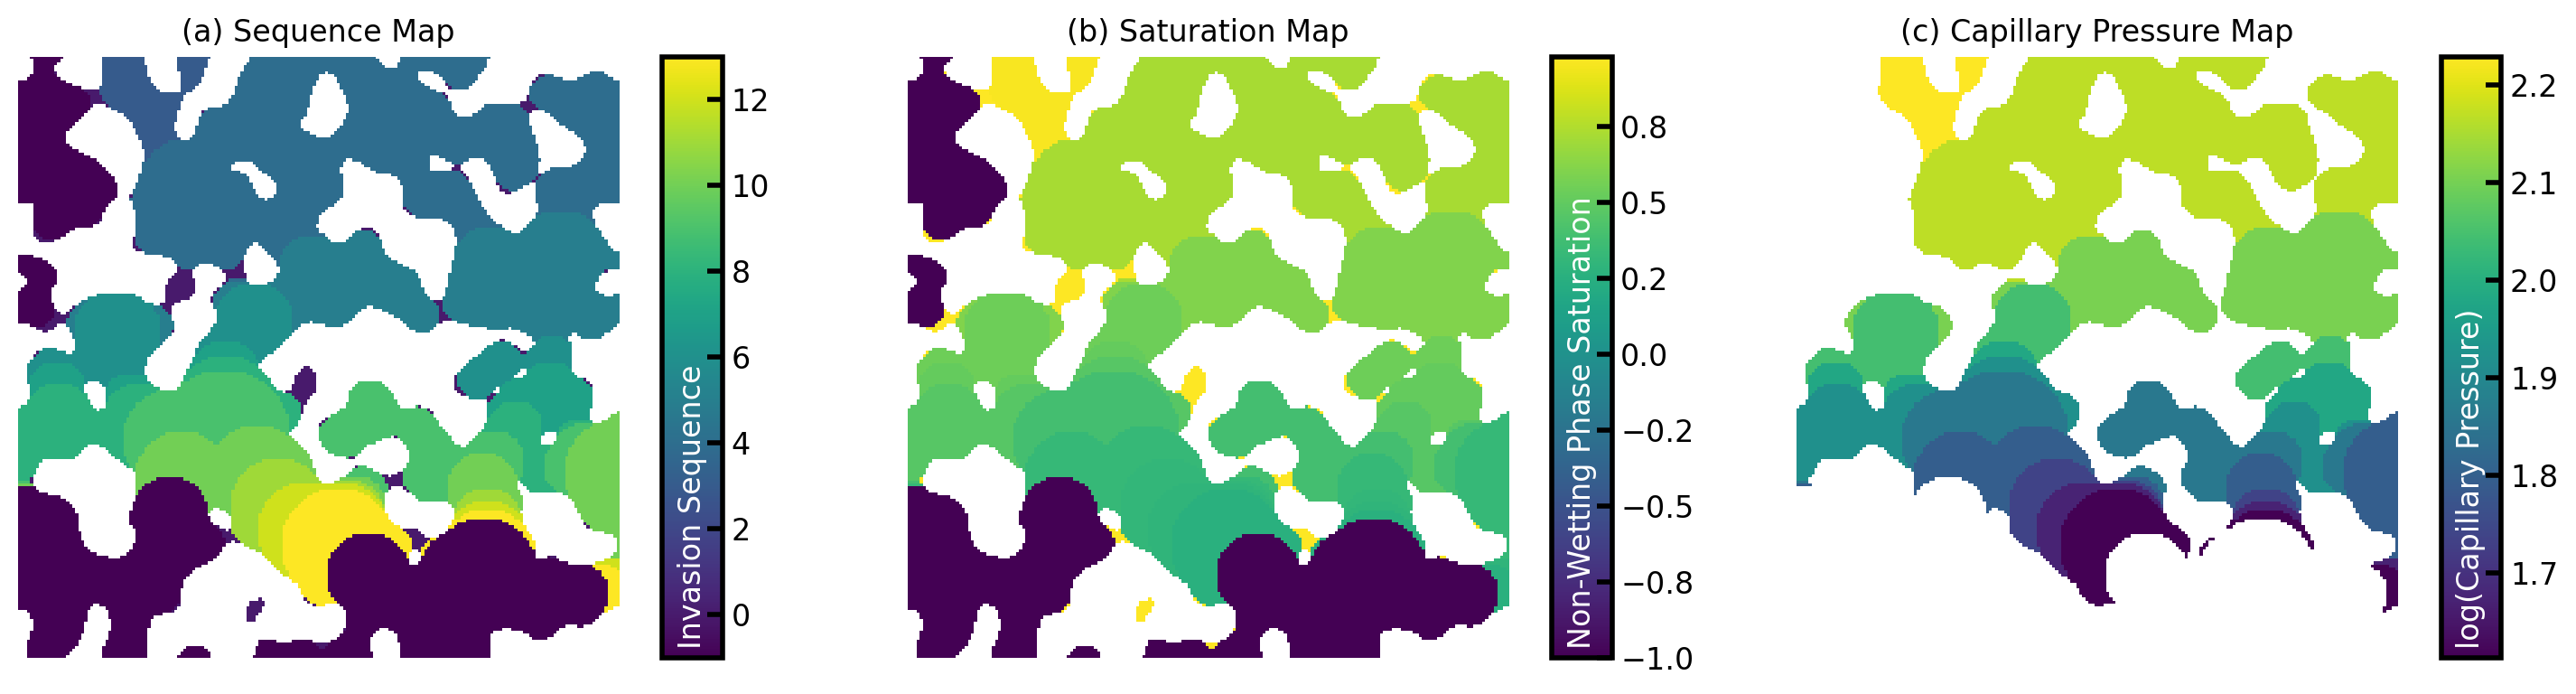

In [8]:
residual = (ps.filters.local_thickness(im) < 5)*im
mask = ps.filters.trim_disconnected_voxels(residual, inlets=ps.generators.borders(im.shape, mode='faces'))
residual = residual * ~mask

fig, ax = plt.subplots(figsize=[4, 4])
ax.imshow(residual/im)
ax.axis(False)
ax.set_title('Locations of residual wetting phase')

imb = ps.simulations.imbibition(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    residual=residual,
)

plot_results(imb)

## `min_size`

The `min_size` argument is passed to the `find_trapped_regions` function.  It limits the minimum size of a cluster that can be considered trapped. For instance, in the above image there can be seen many small isolated trapped pixels next to the walls.  These occur because of the digitized nature of the images, and are probably not realistic.  Supplying `min_size > 0` removes these pixels:

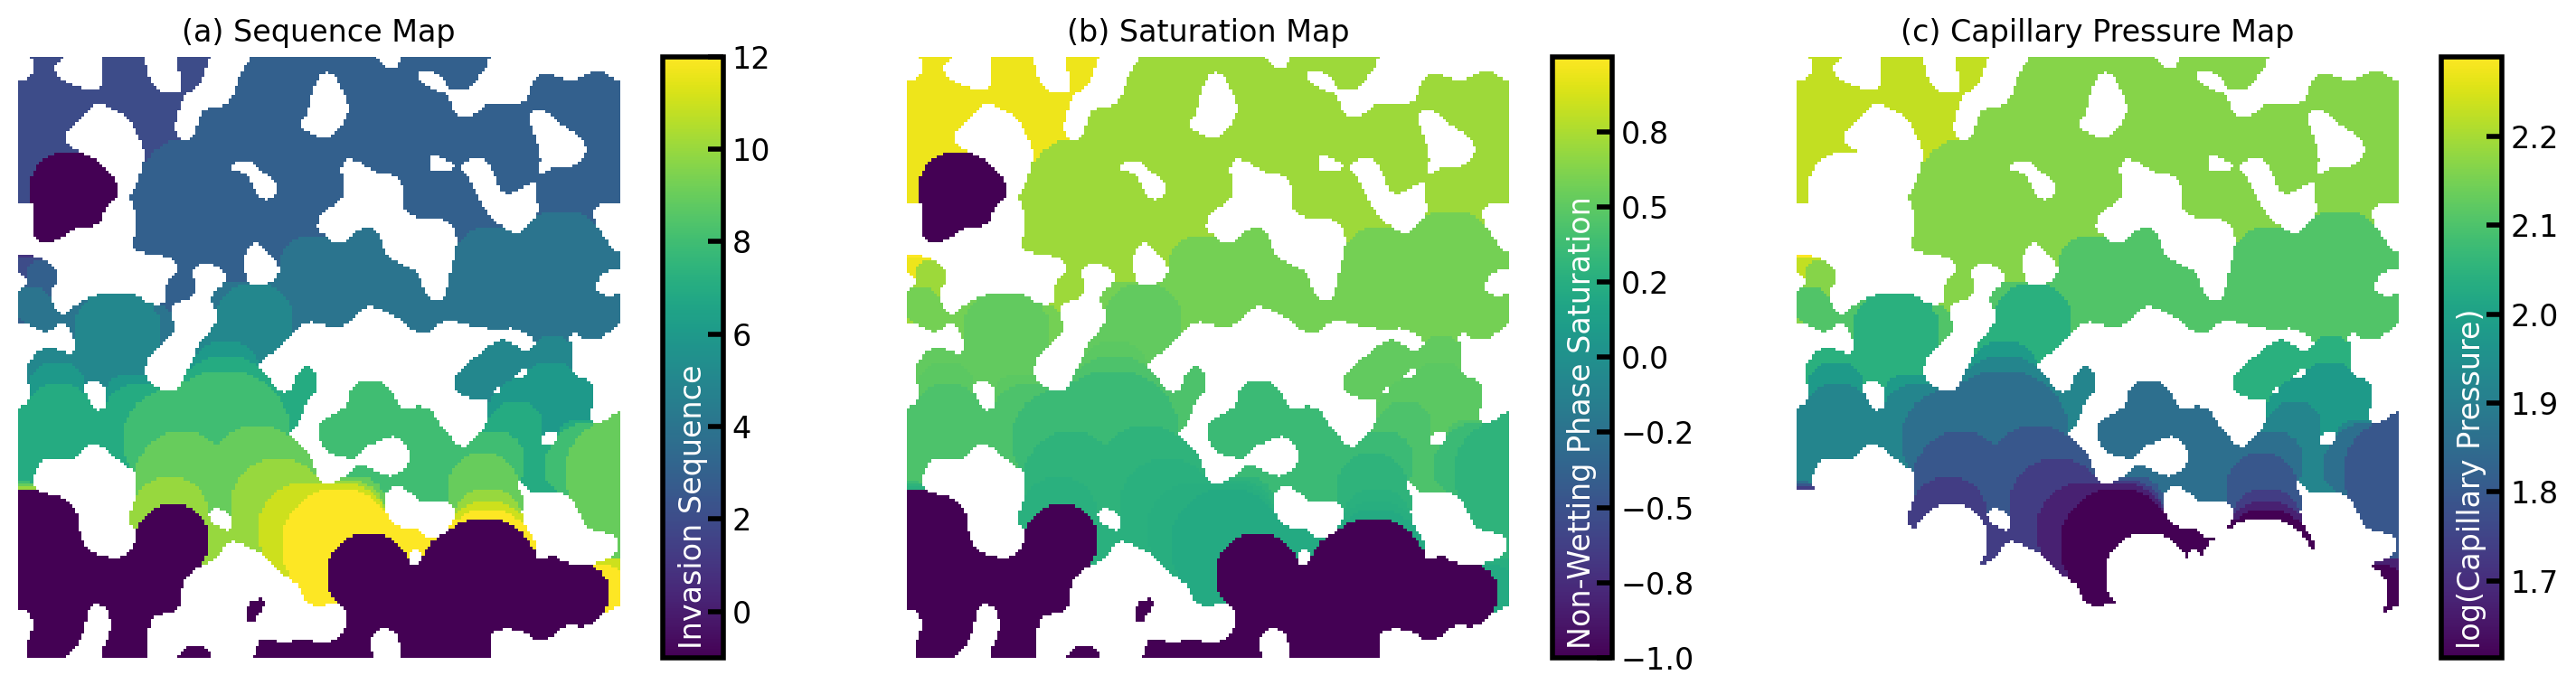

In [9]:
imb = ps.simulations.imbibition(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    min_size=5,
)

plot_results(imb)

## Other Arguments

### `dt`

Like many of the functions in PoreSpy, `invasion` optionally accepts a distance transform. This is computed automatically if `dt` is not provided, but providing one can save a small amount of time if the distance transform has already been computed (which is often the case).

### `return_sizes`
This flag indicates whether or not to compute the size map.  Setting this to `False` can save some time if this result is not required.  

### `steps`

Controls the pressure steps that are applied.  If an integer is supplied than that number of pressure steps between the highest and lowest values in `pc` are used. If a list is supplied, then those values are used (in ascending order).  If `None` is supplied, then every unique value in `pc` is used.  This last option is necessary when comparing to the results of `invasion` for instance. 